### An example of the SIGW inverse problem with the full numerical integration 

In [6]:
import sys
sys.path.append('../')
from jax import vmap, jit, grad, random, jacfwd
from jax.lax import map
import jax.numpy as jnp
import numpy as np
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import warnings
from jax import config
config.update("jax_enable_x64", True)
import numpyro
from spline.omega_gw_jax import OmegaGWjax
from spline.model import fixed_node_model, spline_predict
from getdist import plots,MCSamples,loadMCSamples
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=4,suppress=True)
jnp.set_printoptions(precision=4,suppress=True)
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True) # if using latex in plots
matplotlib.rc('legend', fontsize=16)


#### A simple test curvature power spectrum and $\Omega_{\rm GW}$

(50,)


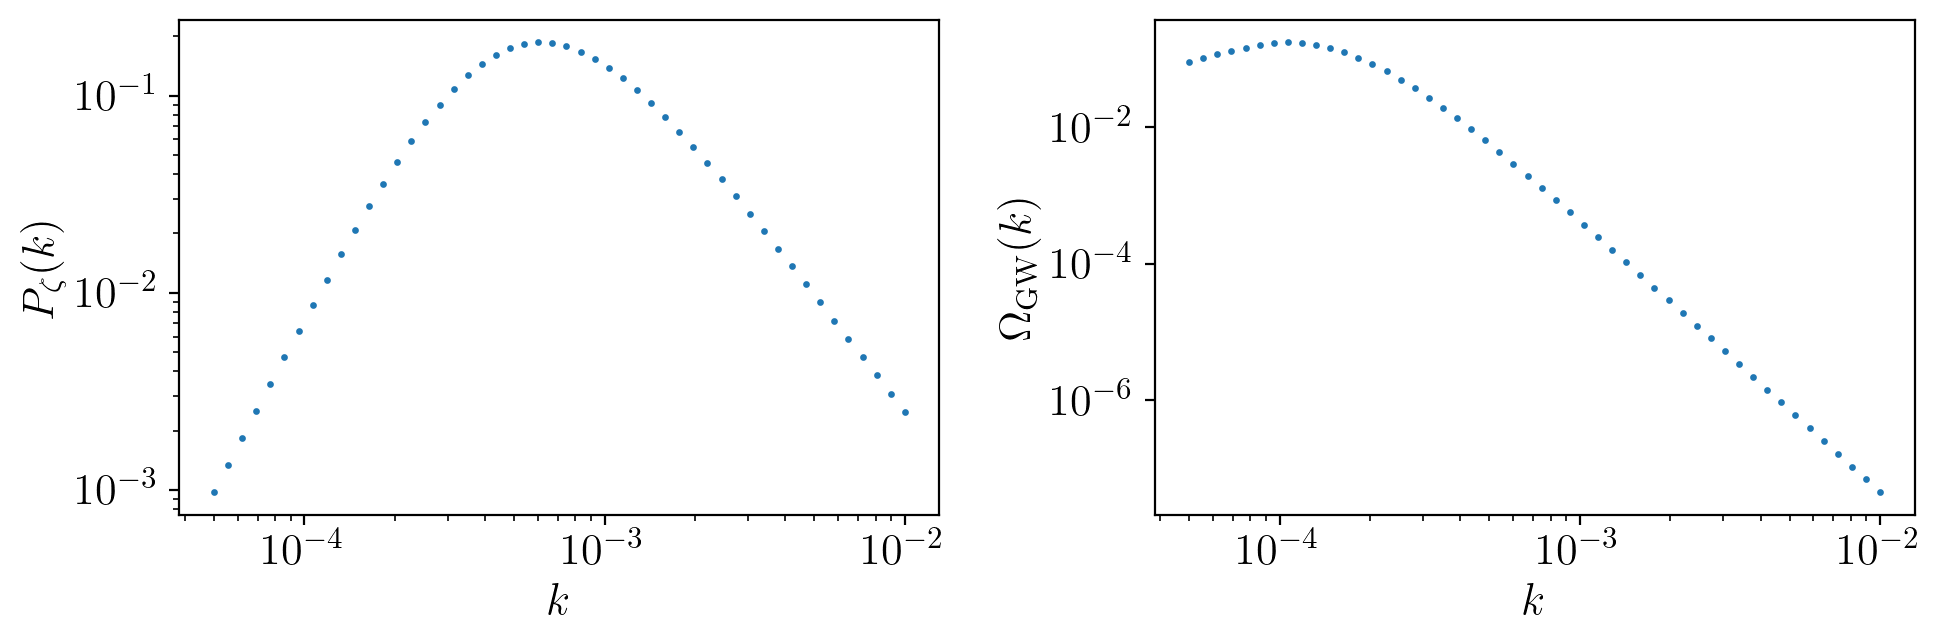

In [53]:
# set up the power spectrum and omgw
psize = 50
ksize = 50
p_arr = jnp.geomspace(5e-5,1e-2,psize)
k_arr = jnp.geomspace(5e-5,1e-2,ksize)

f = jnp.geomspace(5e-5, 1e-2, psize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1, 16)  # First rescaled internal momentum
t = jnp.logspace(-3,3, 100)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def pz(p,pstar=5e-4,n1=3,n2=-2,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return pl1 * pl2 #*osc

omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)


pz_amp = pz(k_arr)
omgw_amp = omgw_calculator(pz,f)

print(omgw_amp.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.scatter(p_arr,pz_amp,s=2)
ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.scatter(f,omgw_amp,s=2)
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout();

#### Let's set up the inference with an uncertainity on the GWB

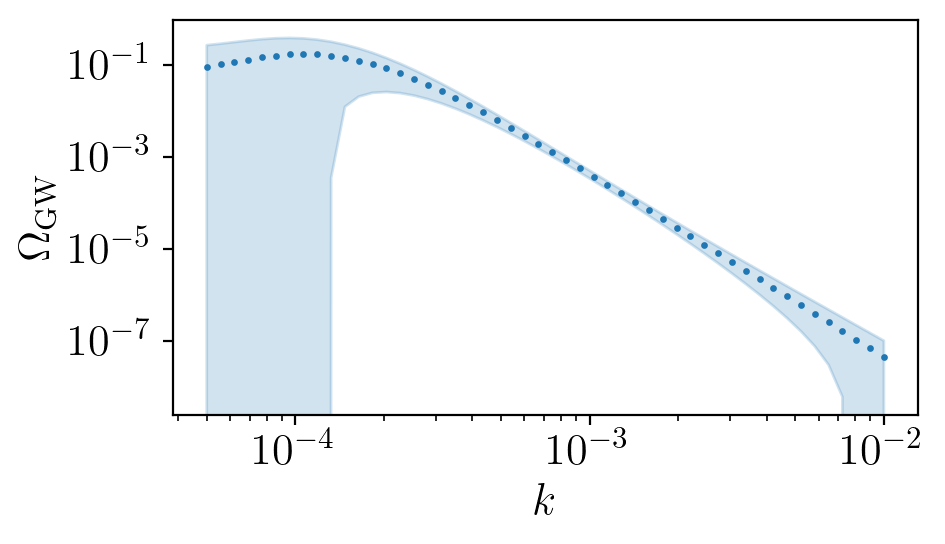

In [54]:
kstar = 1e-3
omks_sigma = omgw_amp*( 0.1*(np.log(k_arr/kstar))**2 + 0.1) # 10% error at kstar + more towards edges
omgw_cov = jnp.diag(omks_sigma)
fig,ax = plt.subplots(1,1,figsize=(5,3.))
ax.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax.scatter(k_arr,omgw_amp,s=2)
ax.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax.set(yscale='log',xscale='log',xlabel=r'$k$')
fig.tight_layout()

In [55]:
# Set up the fixed node interpolator
kmin, kmax = min(p_arr), max(p_arr)
omgw_method_kwargs = {'s': s, 't': t}
pz_model = fixed_node_model(nbins=5,pz_kmin=kmin,pz_kmax=kmax,
                            omgw_karr=k_arr,omgw_means=omgw_amp,
                            omgw_cov=omgw_cov,omgw_method='jax',omgw_method_kwargs=omgw_method_kwargs,y_low=-8,y_high=0)

In [58]:
# run the HMC
samples, _ = pz_model.run_hmc_inference(num_warmup=256,num_samples=768)

sample: 100%|██████████| 1024/1024 [02:40<00:00,  6.40it/s, 25 steps of size 1.07e-01. acc. prob=0.84]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      y[0]     -4.11      2.40     -4.27     -7.50     -0.28    171.48      1.00
      y[1]     -3.10      2.03     -2.82     -5.98     -0.10    106.59      1.00
      y[2]     -5.60      1.63     -5.70     -8.00     -3.02     65.23      1.00
      y[3]     -4.93      1.25     -4.81     -6.97     -2.99     69.74      1.01
      y[4]     -6.54      0.94     -6.71     -7.80     -4.96    110.29      1.00

Number of divergences: 496


#### Now we plot some realisations of the inferred $P_{\zeta}$ from the MCMC samples

(12, 50)


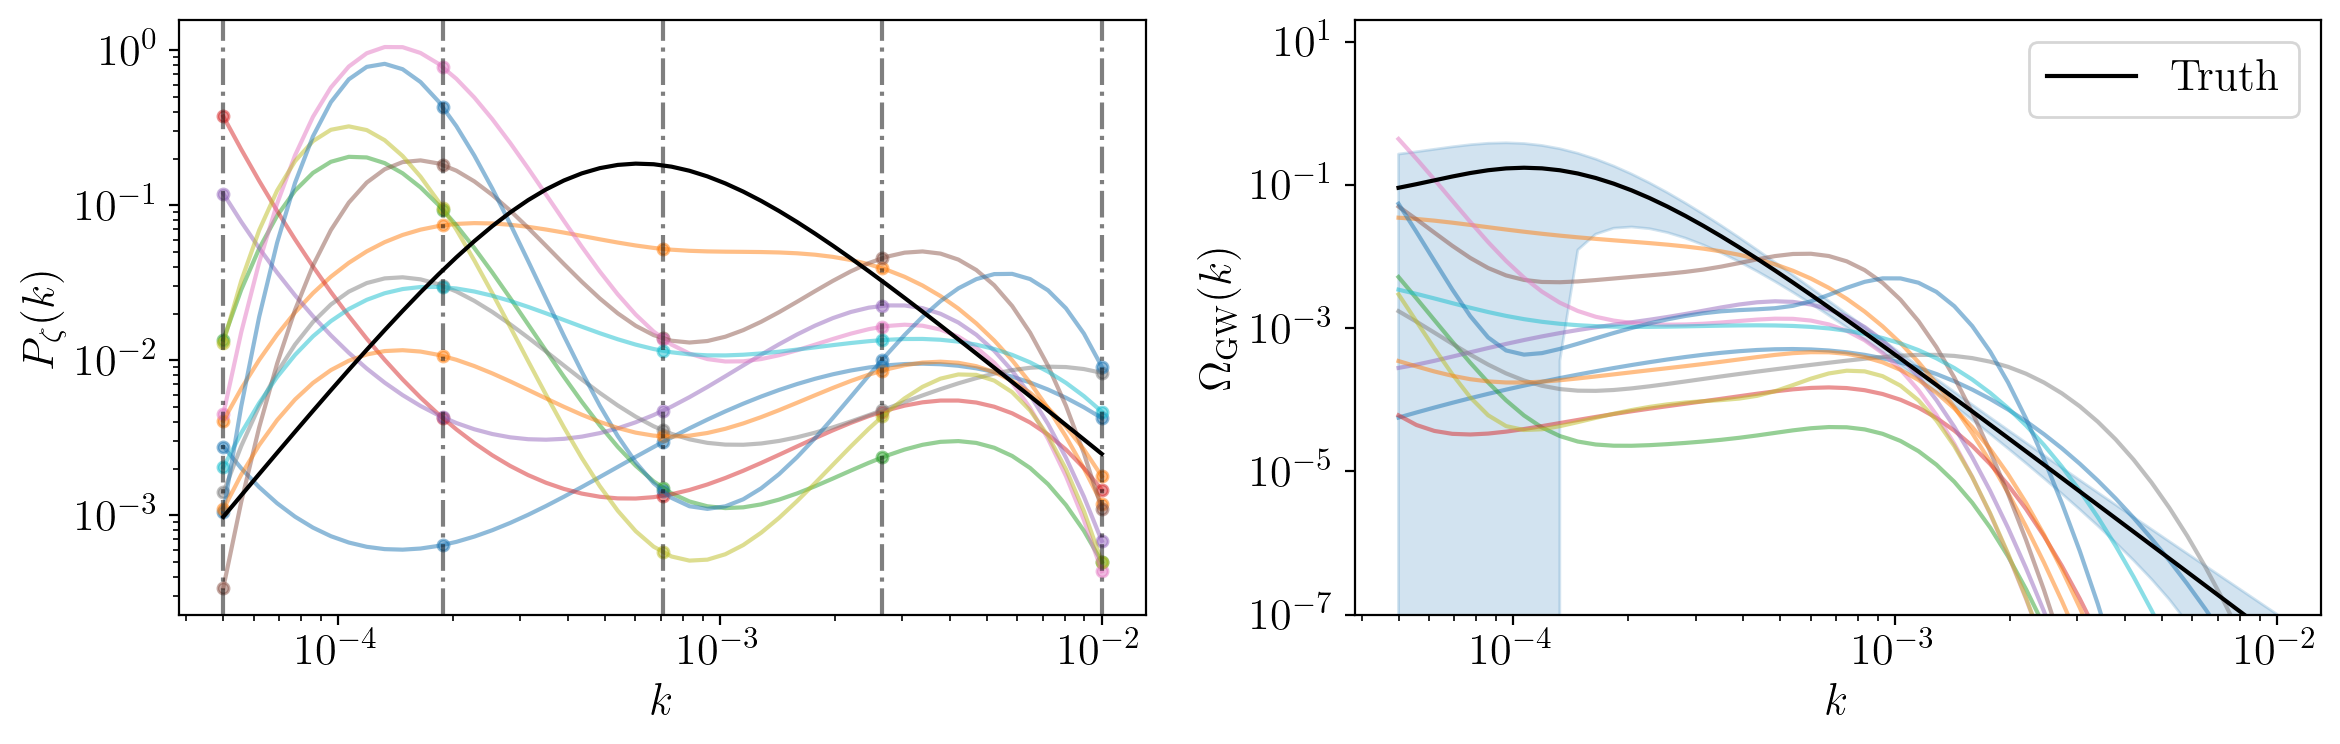

In [66]:
nodes = pz_model.log_k_nodes
ys = samples['y'][::64] #jnp.median(samples['y'])
ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=f)

def omega_f(y):
    pz_func = lambda x: spline_predict(x_train=nodes,y_train=y,x_pred=x)
    res = omgw_calculator(pz_func,f)
    return res
omgw_amps = map(omega_f,ys)

ff = lambda y: spline_predict(x_train=nodes,y_train=y,x_pred=p_arr)
pz_amps = vmap(ff,)(ys)
print(pz_amps.shape)
# omgw_amps = jnp.einsum("pi,pj,kij->pk",pz_amps,pz_amps,omgw_calculator.omkij)
# print(omgw_amps.shape)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

for i,pz in enumerate(pz_amps):
    ax1.loglog(p_arr,pz,alpha=0.5)
    ax1.scatter(jnp.exp(nodes),jnp.exp(ys[i]),s=16,alpha=0.5)
for om in omgw_amps:
    ax2.loglog(k_arr,om,alpha=0.5)
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-7,2e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
fig.tight_layout()

# the dashed lines represent the spline node locations

#### Do an optimization instead of HMC sampling

In [101]:
from spline.model import optim_scipy_bh #, optim_optax
best_params, _ = optim_scipy_bh(x0 = -3*jnp.ones(5),loss = pz_model.loss,bounds=(-7,1),stepsize=0.2,niter=20) 
#best_params, _ =  optim_optax(x0 = -1.5*jnp.ones(5), loss = pz_model.loss, start_learning_rate=0.3 , steps = 200, jump_sdev=1.)
print(best_params)
pz_bf = lambda x: spline_predict(x_train=nodes,y_train=best_params,x_pred=x)
omgw_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
omgw_bf = omgw_calculator(pz_bf,f) #jnp.einsum("i,j,kij->k",pz_bf,pz_bf,omgw_calculator.omkij)

[-4.1984 -2.3775 -2.6321 -3.6123 -5.4829]


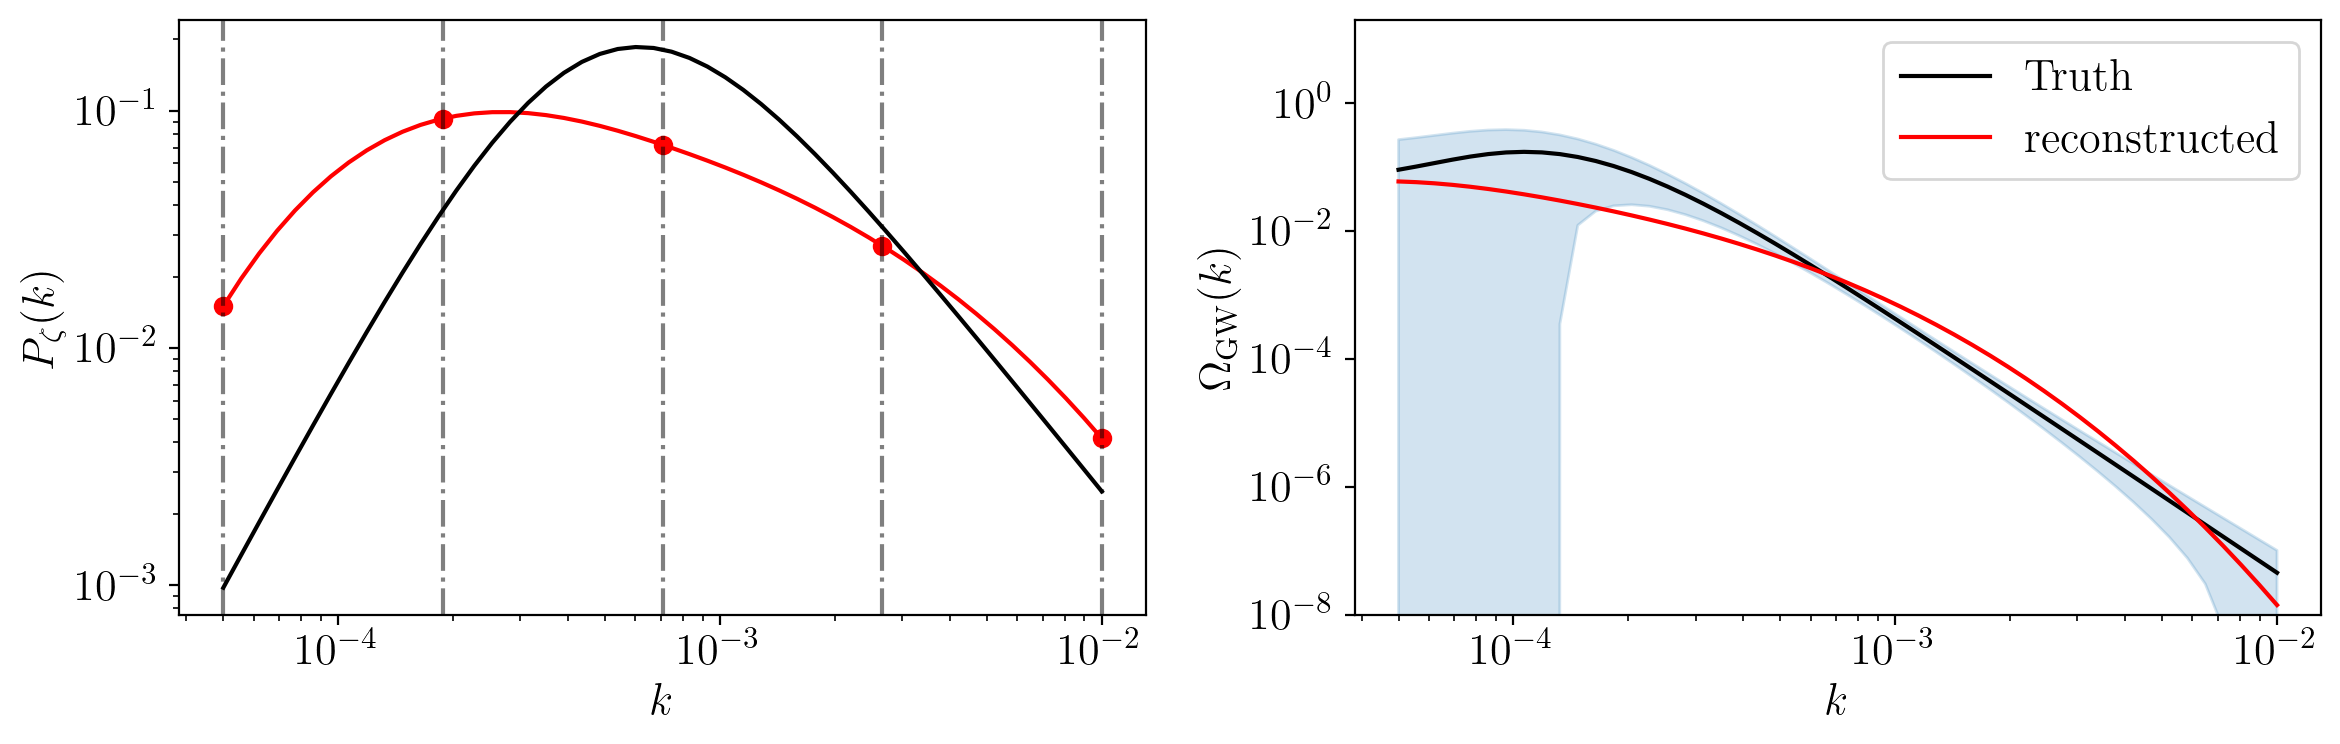

In [102]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.loglog(p_arr,pz_bf(f),color='r')
ax1.loglog(p_arr,pz_amp,color='k',lw=1.5)
ax2.plot(k_arr,omgw_amp,color='k',lw=1.5,label='Truth')
ax2.loglog(k_arr,omgw_bf,color='r',label='reconstructed')
ax2.fill_between(k_arr,omgw_amp+1.96*omks_sigma,omgw_amp-1.96*omks_sigma,alpha=0.2,color='C0')
ax2.set(yscale='log',xscale='log')

ax1.set_ylabel(r'$P_{\zeta}(k)$')
ax1.set_xlabel(r'$k$')
ax2.set_ylim(1e-8,2e1)

ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}(k)$')
ax2.set_xlabel(r'$k$')
ax2.legend()
for val in nodes:
    ax1.axvline(jnp.exp(val),color='k',ls='-.',alpha=0.5)
ax1.scatter(jnp.exp(nodes),jnp.exp(best_params),color='r')
fig.tight_layout()
